## Agent Based Virus Simulation

Author: Christian Graf, March 2020

Goal: Build an agent based monte carlo simulation to predict the dynamics of a virus like infection

Agent based simulations have the capability to model more complex interactions, for example a social structure which is hard to model in analytical "mean field" models.

The focus in this simulation lies on the social structure of interaction as well as the age structure of the population. Explicitly modeled are random interactions, interactions with a group of friends, interactions at work and school, as well as interactions with the familiy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
#helper variables
_personID = 0
_townID = 0

_towns = []

### Tunable parameters

* nTowns: Number of separated towns in order to model distance also in random interacitons
* townSize: Inhabitants of a town
* workRate: Part of the population between age 18 and 65 that is employed
* dailyAttackRate: Base rate of spreading the interaction when two people meet
* contactStrength: Penalty factor for different interactions. Interactions within the family are stronger than random interactions
* curedAfter: Number of days after which a person is cured
* seriousRate: Rate of infections that show serious symptoms. This number is significantly higher for people over 60
* mortalityIfSerious: Rate of people dying from the disease if they have serious symptoms
* nVisitsFriends: Daily visits with friends
* nRandomFriends: Number of random friends
* nCloseFriends: Number of close friends
* averageFamilySize: Size of the average family
* nWorks: Number of different workplaces
* averageWorkSize: Average number of people working at a workplace
* nVisitsTown: Number of random interacitons within a town

In [3]:
_nTowns = 2
_townSize = 1000

_workRate = 0.95

_dailyAttackRate = 0.03

visitTownFactor = 10

_contactStrengthFamily = 1
_contactStrengthFriends = 0.6
_contactStrengthWork = 0.4
_contactStrengthTown = 0.01*visitTownFactor

_curedAfter = 14
_seriousRateOld = 0.8
_seriousRateYoung = 0.01
_mortalityIfSerious = 0.5

_nVisitsFriends = 2
_nRandomFriends = 10
_nCloseFriends = 10

_averageFamilySize = 3
_nWorks = int(_townSize/10)
_averageWorkSize = _townSize/_nWorks

_nVisitsTown = 100/visitTownFactor

### Person

Class for modeling individuals.

Important attributes:

* age
* generation: Which generation they are in the family: child (0), adult (1), grandparents (2)
* isAlive, isInfected, isImmune, isSeriousInfected: Variables holding the state of the persons well beeing
* workplace: The workplace this person is working at
* contacts... : List of people the person is in contact with and where the interactions are sampled from

In [4]:
class Person:
    ID = 0
    age = 40
    generation = 0
    isAlive = True
    isInfected = False
    isImmune = False
    infectedSince = 0
    isSeriousInfected = False
    Quarantaine = False
    
    gotInfectedBy = -1

    
    town = None

    isWorking = False
    isSchool = False
    
    workplace = 0

    isRisk = False    
    mobility = 0
    social = 0
    hygiene = 0
    
    contactsFamily  = []
    contactsFriends = []
    contactsWork    = []
    contactsTown    = []
    contactsEvent   = []  
    

    
    def generateAge(self):
        self.age = np.random.randint(80)
    
    def generateWorking(self):
        x = np.random.randint(100)
        if self.age > 6 and self.age < 18:
            self.isSchool = True
        else:
            self.isSchool = False
            
        if self.age > 65 or self.age < 18:
            self.isWorking = False
        else:
            if x < _workRate*100:
                self.isWorking = True
            else:
                self.isWorking = False
                
    def generateMobility(self):
        self.mobility = np.random.normal()
        
    def generateHygiene(self):
        self.hygiene = np.random.normal()
        
    def generateSocial(self):
        self.social = np.random.normal()
        
    def info(self):
        print("I am", self.age, " years old.")
        print("I live in town #", self.town, " years old.")

        print("Alive:\t", self.isAlive)
        print("Infected:\t", self.isInfected)
        print("Serious Infected:\t", self.isSeriousInfected)
        print("Working:\t", self.isWorking)
        print("School:\t", self.isSchool)

        
    def __init__(self, town, age, generation=1):
        global _personID
        
        self.ID = _personID
        _personID += 1
        
        self.town = town
        self.age = age
        
        #self.generateAge()
        self.generateWorking()
        self.generateMobility()
        self.generateHygiene()
        self.generateSocial()
        
        self.contactsFamily  = []
        self.contactsFriends = []
        self.contactsWork    = []
        self.contactsTown    = []
        self.contactsEvent   = []  


    

### Town

The towns are creating the inhabitants in families and holding the workplaces

In [5]:
class Town:
    ID = 0
    position = (0,0)
    inhabitants = []
    size = 0
    
    workplaces = []
    workplacesP = []
    nWorkplaces = 0
    
    def generateInhabitants(self):
        self.inhabitants = []
        i = 0
        while i < self.size:
            family = self.generateFamily()
            self.inhabitants.extend(family)
            #print(len(family), len(family[0].contactsFamily))
            i += len(family)

    def generateWork(self):
        self.workplaces = []
        self.workplacesP = []
        self.nWorkplaces = _nWorks

        for i in range(self.nWorkplaces):
            size = np.random.randint(0,100)
            self.workplaces.append(size)
            self.workplacesP.append([])
        
        self.workplaces = np.array(self.workplaces)
        self.workplaces = self.workplaces/np.sum(self.workplaces)
        for p in self.inhabitants:
            if p.isWorking:
                p.workplace = np.random.choice(range(self.nWorkplaces),1,replace=False,p=self.workplaces)[0]
                self.workplacesP[p.workplace].append(p)
        
        
                       
    def generateFamily(self):
        # type 0: single, no family, age: 18-80 more likely to be young, or old
        # type 1: pair, age: 18-80
        # type 2: n kids: age 18-80, kids are 0-18
        # grandparents are added to the families depending on age
        family = []
        types = [0,1,2]
        p = [1/3,1/3,1/3]
        
        ty = np.random.choice(types, size=1, replace=False, p=p) 
        
        if ty == 0:
            x = np.random.choice([0,1],size=1,p=[0.7,0.3])
            if x == 0:
                age = np.random.randint(18,90)
            else:
                age = int(np.random.normal(60,15))

            family.append(Person(self.ID, age, 1))
            
            if(age < 60):
                nGrandParents = np.random.randint(1,2)
                for i in range(nGrandParents):
                    ageG = int(age + np.random.normal(25,3))
                    family.append(Person(self.ID, ageG, 2))
            
        elif ty == 1:
            x = np.random.choice([0,1],size=1,p=[0.7,0.3])
            if x == 0:
                age1 = np.random.randint(18,90)
            else:
                age1 = int(np.random.normal(60,10))

            age2 = int(age1 + np.random.normal(0,3))
            family.append(Person(self.ID, age1, 1))            
            family.append(Person(self.ID, age2, 1)) 
            
            if(age1 < 60):
                nGrandParents = np.random.poisson(1.5)
                for i in range(nGrandParents):
                    age = int(age1 + np.random.normal(25,3))
                    family.append(Person(self.ID, age, 2))
                
        elif ty == 2:
            kidMaxAge = 0
            
            nKids = np.random.poisson(1.7)
            nGrandParents = np.random.poisson(1.5)

            for i in range(nKids):
                age = np.random.randint(0,20)
                if age > kidMaxAge:
                    kidMaxAge = age
                family.append(Person(self.ID, age, 0)) 
            
                
            age1 = kidMaxAge + np.random.normal(26,3)
            age2 = int(age1 + np.random.normal(0,3))
            
            family.append(Person(self.ID, age1, 1))            
            family.append(Person(self.ID, age2, 1))     

            for i in range(nGrandParents):
                age = int(age1 + np.random.normal(25,3))
                family.append(Person(self.ID, age, 2)) 
            
        if len(family) == 2:
            family[0].contactsFamily.append(family[1])
            family[1].contactsFamily.append(family[0])
 
        if len(family) > 2:

            for i in range(len(family)-1):
                f1 = family[i]
                
                for j in range(i+1,len(family)):
                    f2 = family[j]
                    f1.contactsFamily.append(f2)
                    f2.contactsFamily.append(f1)
            
        return family
            
    def __init__(self):
        global _townID
        
        self.ID = _townID
        _townID += 1
        
        self.size = _townSize
        
        self.generateInhabitants()
        self.generateWork()

In [6]:
# currently not implemented

class HealthSystem:
    treatment = 1
    maxInTreatment = 1000
    
    def testPerson(self,p):
        return 0
    

### Disease

The disease class takes care of how to infect and how to cure people

In [7]:
class Disease:
    
    def infect(self,c,day):
        c.isInfected = True
        c.infectedSince = day
        x = np.random.randint(1000)
        if c.age > 60:
            if x < _seriousRateOld*1000:
                c.isSeriousInfected = True
        else:
            if x < _seriousRateYoung*1000:
                c.isSeriousInfected = True
    
    def cure(self,p):
        p.isInfected = False
        p.isSeriousInfected = False
        p.isImmune = True
    

### MathModel

Calculating analytical predictions with SIR-Model as a baseline model

In [8]:
class MathModel:
    S = 0
    I = 0
    R = 0
    
    S_ = []
    I_ = []
    R_ = []
    
    beta = 0
    gamma = 0

    
    def __init__(self):
        self.S = _nTowns*_townSize - 10
        self.I = 10
        self.R = 0
        
        self.S_ = []
        self.I_ = []
        self.R_ = []
        
        self.S_.append(self.S)
        self.I_.append(self.I)
        self.R_.append(self.R)
        
        self.beta = (_contactStrengthFamily*_averageFamilySize + _contactStrengthFriends*_nVisitsFriends + _contactStrengthWork*_averageWorkSize*_workRate*0.6 + _contactStrengthTown * _nVisitsTown)*_dailyAttackRate #contacts with 100% infection rate
        self.gamma = 1/_curedAfter
    
        print("Math Model initialized with:")
        print("Beta:",self.beta)
        print("Gamma:",self.gamma)
        
    def calculateStep(self):
        N = self.S+self.I+self.R
        
        self.S = self.S - self.beta*self.S*self.I/N
        self.I = self.I + self.beta*self.S*self.I/N - self.gamma*self.I
        self.R = self.R + self.gamma*self.I
        
        self.S_.append(self.S)
        self.I_.append(self.I)
        self.R_.append(self.R)    

### Simulation

Here, the simulation is progressing.

* step(): Method for calculating one day in the simulation; executing interactions
* patientZero(): Infect initial patients

In [9]:
class Simulation:
    
    day = 0
    disease = None
    model = None
    
    def __init__(self):
        self.disease = Disease()
        self.model = MathModel()        
    
    def generateTowns(self):
        global _towns
        _towns = []
        
        for i in range(_nTowns):
            _towns.append(Town())
    
    def generateFriends(self):
        for t in tqdm(_towns):
            i = 0
            for p in t.inhabitants:
                #random friends
                nRandomFriends = _nRandomFriends
                if _nRandomFriends > 0:
                    p.contactsFriends = list(np.random.choice(t.inhabitants, nRandomFriends, replace=False))
                else:
                    p.contactsFriends = []
                
                nCloseFriends = _nCloseFriends
                for j in range(0,nCloseFriends):
                    if i+1+j >= len(t.inhabitants): 
                        if len(p.contactsFriends) == 0:
                            p.contactsFriends.append(t.inhabitants[i-1])
                        break
                    else:
                        p.contactsFriends.append(t.inhabitants[i+1+j])
                i += 1

                
    def patientZero(self):
        t = np.random.choice(_towns, 1)[0]
        p = np.random.choice(t.inhabitants, 1)[0]
        p.isInfected = True
        return p
    
    def step(self):
        for t in _towns:
            for p in t.inhabitants:
                if p.isAlive == False:
                    continue
                    
                if p.isInfected and p.infectedSince  + _curedAfter < self.day:
                    self.disease.cure(p)
                    
                if p.isSeriousInfected:
                    x = np.random.randint(0,1000)
                    if x < _mortalityIfSerious/_curedAfter*1000:
                        p.isAlive = False
                        p.isImmune = False
                        p.isSeriousInfected = False
                        p.isInfected = False

                    
                if p.isInfected and p.infectedSince < self.day:
                    #number of people visited:
                    
                    self.visitFriends(p)
                    self.visitFamily(p)
                    self.visitTown(p, t)
                    
                    #nFamily = np.random.poisson(3)
                    #visits = np.random.choice(p.contactsFamily,min(nFamily,len(p.contactsFamily)))
                    #for c in visits:
                    #    if not c.isImmune and not c.isInfected:
                    #        if np.random.randint(1000) < _secondaryAttackRate*_contactStrengthFriends*1000:
                    #            c.isInfected = True
                    #            c.infectedSince = self.day
                
            self.updateWork(t)
            
        self.model.calculateStep()
        
        self.day += 1
 
    def updateWork(self,t):
        for w in t.workplacesP:
            countInfected = 0
            countNotInfected = 0
            
            for p in w:
                if p.isInfected:
                    countInfected += 1
                else:
                    countNotInfected += 1
            
            #print(countInfected,countNotInfected)
            
            for c in w:
                if not c.isImmune and not c.isInfected and c.isAlive:
                    if np.random.randint(1000) < _dailyAttackRate*_contactStrengthWork*1000*countInfected:
                        self.disease.infect(c,self.day)
                        c.gotInfectedBy = 2

    def visitFriends(self,p):
        nFriends = max(0,int(_nVisitsFriends*(1+p.social)))
        visits = np.random.choice(p.contactsFriends,min(nFriends, len(p.contactsFriends)))
        
        for c in visits:
            if not c.isImmune and not c.isInfected and c.isAlive:
                if np.random.randint(1000) < _dailyAttackRate*_contactStrengthFriends*1000:
                    self.disease.infect(c,self.day)
                    c.gotInfectedBy = 1

                                
    def visitFamily(self,p):
        for c in p.contactsFamily:
            if not c.isImmune and not c.isInfected and c.isAlive:
                if np.random.randint(1000) < _dailyAttackRate*_contactStrengthFamily*1000:
                    self.disease.infect(c, self.day)
                    c.gotInfectedBy = 0


    def visitTown(self,p,t):
        nTownVisits = max(0,int(_nVisitsTown))
        visits = np.random.choice(t.inhabitants,min(nTownVisits, len(t.inhabitants)))
        
        for c in visits:
            if not c.isImmune and not c.isInfected and c.isAlive:
                if np.random.randint(1000) < _dailyAttackRate*_contactStrengthTown*1000:
                    self.disease.infect(c, self.day)
                    c.gotInfectedBy = 3
    
                    
                    
    def countInfected(self):
        count = 0
        for t in _towns:
            for p in t.inhabitants:
                if p.isInfected:
                    count += 1
        return count
                    
    def countImmune(self):
        count = 0
        for t in _towns:
            for p in t.inhabitants:
                if p.isImmune:
                    count += 1
        return count
    
    def countSerious(self):
        count = 0
        for t in _towns:
            for p in t.inhabitants:
                if p.isSeriousInfected:
                    count += 1
        return count
    
    def countDead(self):
        count = 0
        for t in _towns:
            for p in t.inhabitants:
                if not p.isAlive:
                    count += 1
        return count
    
    def countInfectedBy(self):
        count0 = 0
        count1 = 0
        count2 = 0
        count3 = 0
        for t in _towns:
            for p in t.inhabitants:
                if p.gotInfectedBy == 0:
                    count0 += 1
                if p.gotInfectedBy == 1:
                    count1 += 1
                if p.gotInfectedBy == 2:
                    count2 += 1
                if p.gotInfectedBy == 3:
                    count3 += 1
        return  count0,count1,count2,count3
 

    def returnInfected(self):
        infected = []
        for t in _towns:
            for p in t.inhabitants:
                if p.isInfected:
                    infected.append(1)
                else:
                    infected.append(0)
        return infected
    
    
    def returnImmune(self):
        immune = []
        for t in _towns:
            for p in t.inhabitants:
                if p.isImmune:
                    immune.append(1)
                else:
                    immune.append(0)
        return immune 
    
    def returnAgeDistribution(self):
        age = []
        for t in _towns:
            for p in t.inhabitants:
                if p.isAlive:
                    age.append(p.age)
                
        return age    
                    

Setting up the simulation

In [10]:
sim = Simulation()
sim.generateTowns()
sim.generateFriends()
ageDistributionBeginning = sim.returnAgeDistribution()

for i in range(10):
    sim.patientZero()#.info()


Math Model initialized with:
Beta: 0.22440000000000002
Gamma: 0.07142857142857142


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Running the simulation

In [11]:
# Statistics
infections = []
serious = []
dead = []
immune = []
both = []

inf0 = []
inf1 = []
inf2 = []
inf3 = []

# Number of days to simulate
nDays = 200
for i in tqdm(range(nDays)):
    sim.step()
    nInf = sim.countInfected()
    nImm = sim.countImmune()
    nSerious = sim.countSerious()
    nDead = sim.countDead()
    
    nInf0, nInf1, nInf2, nInf3 = sim.countInfectedBy()

    
    infections.append(nInf) 
    inf0.append(nInf0) 
    inf1.append(nInf1) 
    inf2.append(nInf2) 
    inf3.append(nInf3) 
    serious.append(nSerious) 
    dead.append(nDead) 
    immune.append(nImm)
    both.append(nDead+nImm)
    
xInfected = sim.returnInfected()
xImmune = sim.returnImmune()

100%|██████████| 200/200 [00:49<00:00,  4.00it/s]


### Plotting the dynamics of the outbreak. 

The broken lines show the predictions of the SIR model, while the solid lines show the outcome of the simulation

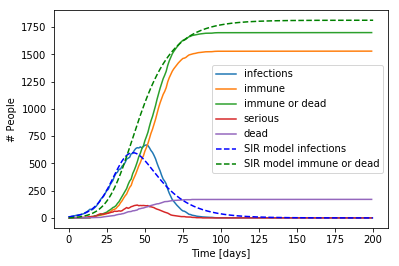

In [12]:
plt.plot(infections, label="infections")
plt.plot(immune, label="immune")
plt.plot(both, label="immune or dead")
plt.plot(serious, label="serious")
plt.plot(dead, label="dead")
plt.plot(sim.model.I_,"b--", label="SIR model infections")
plt.plot(sim.model.R_,"g--", label="SIR model immune or dead")
plt.xlabel("Time [days]")
plt.ylabel("# People")
plt.legend()
plt.show()

### Which social interaction got people infected?

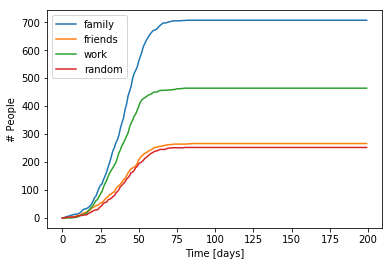

In [13]:
plt.plot(inf0, label="family")
plt.plot(inf1, label="friends")
plt.plot(inf2, label="work")
plt.plot(inf3, label="random")
plt.xlabel("Time [days]")
plt.ylabel("# People")
plt.legend()
plt.show()

### Age distribution of the population before and after the outbreak

In [14]:
plt.hist(ageDistributionBeginning, bins=90, label="before")
plt.hist(sim.returnAgeDistribution(), bins=90, label="after")
plt.xlabel("Age [years]")
plt.ylabel("# Entries")
plt.legend()
plt.show()